## S2 - L5 - Spam Classifier


The goal is develop a model based in natural language proccessing, NLP, that is able to predict if a message is spam. I'll data preprocessing, transformig text to vectors and train a classifier to this task.

### 0. Imports

In [3]:
%pip uninstall -y keras
%pip install -U "tensorflow==2.15.*"


Found existing installation: keras 3.12.0
Uninstalling keras-3.12.0:
  Successfully uninstalled keras-3.12.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.* (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.*


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("TF:", tf.__version__)


TF: 2.20.0


In [13]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import spacy 


from nltk.corpus import stopwords
from wordcloud import WordCloud
import re


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import spacy 
import nltk

import gensim.downloader
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM
from transformers import BertTokenizer, TFBertForSequenceClassification, pipeline, TFBertModel, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from sklearn.model_selection import train_test_split
from scipy.special import softmax

import torch

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juanq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 1. Data Preprocessing


Load the data spam.csv


In [14]:

import chardet
with open("spam.csv", "rb") as f:
    enc = chardet.detect(f.read(100_000))["encoding"]
df = pd.read_csv("spam.csv", encoding=enc)
df.head


<bound method NDFrame.head of         v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN  

### 2. Data Cleaning

Erease innecesary columns. 

In [15]:
df = df.rename(columns={"v1": "label", "v2":"message"})

#keep only important columns

df = df[["label","message"]]

#basic cleaning

df = df.dropna().drop_duplicates()
print(df.sample(10))

df = df[df["label"].isin(["ham","spam"])]
print("Dataset size: ",df.shape)
print("Number of samples of each class: \n ", df["label"].value_counts())



     label                                            message
1617   ham                      Did u download the fring app?
2064   ham  Pass dis to all ur contacts n see wat u get! R...
1272   ham                                              Ok...
3020   ham                     Am in film ill call you later.
3642   ham  Sorry, left phone upstairs. OK, might be hecti...
1520  spam  URGENT! Your Mobile No was awarded a å£2,000 B...
1159   ham  Yun buying... But school got offer 2000 plus o...
3986  spam  Ringtone Club: Gr8 new polys direct to your mo...
3217   ham    Don know:)this week i'm going to tirunelvai da.
539    ham  I am in tirupur da, once you started from offi...
Dataset size:  (5169, 2)
Number of samples of each class: 
  label
ham     4516
spam     653
Name: count, dtype: int64


### 3. Text preprocessing

Rewrite text to lowcase, erease special characters, tokenize, erease stopwords, stemming

Plot some stopwords


In [16]:
stopwords.words('spanish')[:10]

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']

In [17]:
# === Normalizar columnas a ['label', 'message'] y limpieza básica ===



# Dataset típico: v1 = etiqueta, v2 = texto
if "v1" in df.columns and "v2" in df.columns:
    df = df.rename(columns={"v1": "label", "v2": "message"})
elif {"label", "message"}.issubset(df.columns):
    pass
else:
    # Heurística si los nombres son distintos
    label_candidate = None
    for c in df.columns:
        if df[c].dtype == "object" and df[c].nunique(dropna=True) <= 5:
            label_candidate = c
            break
    message_candidate, best_len = None, -1
    for c in df.columns:
        if df[c].dtype == "object":
            avg_len = df[c].astype(str).str.len().mean()
            if c != label_candidate and avg_len > best_len:
                best_len, message_candidate = avg_len, c
    if label_candidate and message_candidate:
        df = df.rename(columns={label_candidate: "label", message_candidate: "message"})

# Conservar solo columnas de interés
if {"label", "message"}.issubset(df.columns):
    df = df[["label", "message"]]
else:
    raise RuntimeError(f"No se pudieron identificar columnas de etiqueta/texto. Columnas: {df_raw.columns.tolist()}")

# Limpiezas básicas
df = df.dropna().drop_duplicates()
df["label"] = df["label"].astype(str).str.lower().str.strip()
df = df[df["label"].isin(["ham", "spam"])]

print(df.shape)
display(df.head(8))
print(df["label"].value_counts())


(5169, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...


label
ham     4516
spam     653
Name: count, dtype: int64


In [18]:
# === Preprocesado de texto: minúsculas, signos, stopwords ES/EN ===

spanish_sw = {
    "de","la","que","el","en","y","a","los","del","se","las","por","un","para","con","no","una",
    "su","al","lo","como","más","pero","sus","le","ya","o","fue","ha","sí","porque","esta","son",
    "entre","cuando","muy","sin","sobre","también","me","hasta","hay","donde","quien","desde",
    "todo","nos","durante","todos","uno","les","ni","contra","otros","ese","eso","ante","ellos",
    "e","esto","mí","antes","algunos","qué","unos","yo","otro","otras","otra","él","tanto","esa",
    "estos","mucho","quienes","nada","muchos","cual","poco","ella","estar","estas","algunas",
    "algo","nosotros","mi","mis","tú","te","ti","tu","tus","ellas","vosotros","vosotras","os",
    "mío","mía","míos","mías","tuyo","tuya","tuyos","tuyas","suya","suyo","suyos","suyas","nuestro",
    "nuestra","nuestros","nuestras","vuestro","vuestra","vuestros","vuestras","esos","esas","estoy",
    "estás","está","estamos","estáis","están","esté","estés","estemos","estéis","estén","estaré",
}
english_sw = {
    "the","a","an","in","on","at","and","or","to","for","of","is","are","was","were","be","been",
    "am","as","by","with","from","that","this","it","its","you","your","yours","me","my","we","our",
    "they","their","them","he","she","his","her","will","would","can","could","should","if","then",
    "so","than","about","into","over","under","again","more","most","other","some","such","no","not",
    "only","own","same","too","very","just","now","also","any","both","each","few","how","i",
}
STOPWORDS = spanish_sw.union(english_sw)

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        s = str(s)
    s = s.lower()
    s = re.sub(r"[^a-záéíóúñü\s]", " ", s)  # mantener letras (es/en) y espacios
    s = re.sub(r"\s+", " ", s).strip()
    tokens = [t for t in s.split() if t not in STOPWORDS]
    return " ".join(tokens)

df["clean"] = df["message"].apply(clean_text)
df = df[df["clean"].str.len() > 0]

display(df[["label","message","clean"]].head(10))
print("Filas tras limpieza:", df.shape[0])


,label,message,clean
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available bugis n ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah don t think goes usf lives around here though
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darling s week s word back d...
6,ham,Even my brother is not like to speak with me. ...,even brother like speak treat like aids patent
7,ham,As per your request 'Melle Melle (Oru Minnamin...,per request melle melle oru minnaminunginte nu...
8,spam,WINNER!! As a valued network customer you have...,winner valued network customer have selected r...
9,spam,Had your mobile 11 months or more? U R entitle...,had mobile months u r entitled update latest c...


Filas tras limpieza: 5165


Numerical representation. Using TfidVectorizer

In [21]:
vectorizer = TfidfVectorizer(max_features = 5000, ngram_range = (1,2), min_df=2)
X = vectorizer.fit_transform(df['clean'])

Change labels -> one-hot encoding

In [24]:
y = (df['label'].astype(str).str.lower().str.strip()  == "spam").astype(int).values

Stratified Splits

In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X.shape, X_train.shape, X_val.shape, np.bincount(y), np.bincount(y_train), np.bincount(y_val)


((5165, 5000),
 (4132, 5000),
 (1033, 5000),
 array([4512,  653]),
 array([3610,  522]),
 array([902, 131]))

### 4. Build model


3 options -> naive bayes, logistic regresion, neural network

**Logistic regresion** -> simple efective for binary classification.

**Naive Bayes** -> ideal for text, quick and effective. 

**Neural Network** -> heavy and slow, requires computational power + tokenizer + padding

In [27]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter = 1000)
clf.fit(X_train,y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### 5. Model evaluation -> accuracy, precision, f1-score, confussion matrix

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = clf.predict(X_val)
y_proba = clf.predict_proba(X_val)[:,1]

acc = accuracy_score(y_val,y_pred)
print(f"Acuracy score: {acc:.4f}")

report = classification_report(y_val,y_pred,target_names = {"ham","spam"},output_dict=True)
pd.DataFrame(report).T


Acuracy score: 0.9564


,precision,recall,f1-score,support
spam,0.952482,1.000000,0.975663,902.000000
ham,1.000000,0.656489,0.792627,131.000000
accuracy,0.956438,0.956438,0.956438,0.956438
macro avg,0.976241,0.828244,0.884145,1033.000000
weighted avg,0.958508,0.956438,0.952451,1033.000000


Plotting confusion matrix

Text(0.5, 0, 'Predicted value')

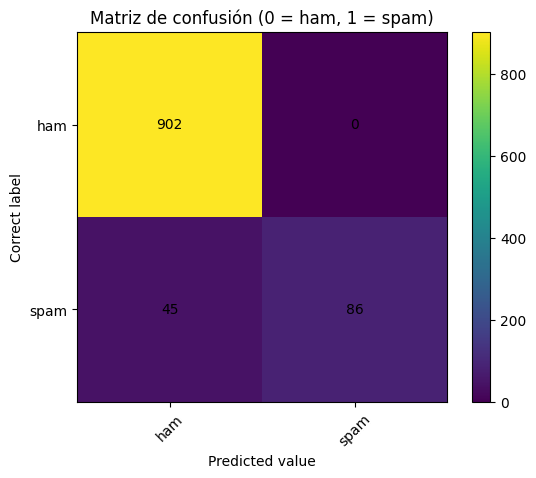

In [46]:

cm = confusion_matrix(y_val,y_pred,labels=[0,1])

plt.figure()
plt.imshow(cm, interpolation = "nearest")
plt.title("Matriz de confusión (0 = ham, 1 = spam)")
plt.colorbar()
ticks = [0,1]
plt.xticks(ticks,["ham","spam"], rotation = 45)
plt.yticks(ticks,["ham","spam"])

#show values

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i,cm[i,j],ha = "center", va = "center")

plt.ylabel("Correct label")
plt.xlabel("Predicted value")


We underperform identifiying spam, tending to classify as ham spam and not viceversa

### 6. Saving model, metrics and vectorizer

In [48]:
import json, pickle, os

artifacts = {
    "vectorizer_path": "/mnt/data/tfidf_vectorizer.pkl",
    "model_path": "/mnt/data/logreg_spam_model.pkl",
    "report_path": "/mnt/data/evaluation_report.json",
}

os.makedirs(os.path.dirname(artifacts["vectorizer_path"]))

with open(artifacts["vectorizer_path"], "wb") as f:
    pickle.dump(vectorizer, f)

with open(artifacts["model_path"], "wb") as f:
    pickle.dump(clf, f)

with open(artifacts["report_path"], "w", encoding="utf-8") as f:
    json.dump(
        {
            "accuracy": float(acc),
            "classification_report": report,
            "confusion_matrix": cm.tolist(),
        },
        f,
        ensure_ascii=False,
        indent=2,
    )

artifacts


{'vectorizer_path': '/mnt/data/tfidf_vectorizer.pkl',
 'model_path': '/mnt/data/logreg_spam_model.pkl',
 'report_path': '/mnt/data/evaluation_report.json'}

### 7. Other models -> Naive Bayes , LTSM 

**Naive Bayes**

Applies Bayes Theorem to estimate the probability or the caracteristics given a certain class. It is naive cause it supposes that events are independet between each other given the class

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
X_counts = count_vect.fit_transform(df["clean"])
y = (df["label"].str.lower().str.strip() == "spam").astype(int).values

X_tr, X_va, y_tr, y_va = train_test_split(
    X_counts, y, test_size=0.2, random_state=42, stratify=y
)

nb = MultinomialNB(alpha=0.1)
nb.fit(X_tr, y_tr)

y_pred  = nb.predict(X_va)
y_proba = nb.predict_proba(X_va)[:, 1]


**LTSM**

In [52]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(256, ),
    activation='relu',
    alpha=1e-4,          # L2 (weight decay)
    learning_rate='adaptive',
    max_iter=20,       
    random_state=42
)
mlp.fit(X_train, y_train)

y_pred  = mlp.predict(X_val)
y_proba = mlp.predict_proba(X_val)[:, 1]


c:\Users\juanq\Desktop\repo\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

def eval_and_show(y_true, y_pred, name="Modelo"):
    print(f"[{name}] Accuracy:", accuracy_score(y_true, y_pred))
    print(pd.DataFrame(classification_report(y_true, y_pred, target_names=["ham","spam"], output_dict=True)).T)
    print(confusion_matrix(y_true, y_pred, labels=[0,1]))

# Ejemplos:
eval_and_show(y_val, y_pred, "LogReg")
eval_and_show(y_val, y_pred, "NaiveBayes")
eval_and_show(y_val, y_pred, "MLP")



[LogReg] Accuracy: 0.9816069699903195
              precision    recall  f1-score      support
ham            0.981461  0.997783  0.989555   902.000000
spam           0.982759  0.870229  0.923077   131.000000
accuracy       0.981607  0.981607  0.981607     0.981607
macro avg      0.982110  0.934006  0.956316  1033.000000
weighted avg   0.981626  0.981607  0.981124  1033.000000
[[900   2]
 [ 17 114]]
[NaiveBayes] Accuracy: 0.9816069699903195
              precision    recall  f1-score      support
ham            0.981461  0.997783  0.989555   902.000000
spam           0.982759  0.870229  0.923077   131.000000
accuracy       0.981607  0.981607  0.981607     0.981607
macro avg      0.982110  0.934006  0.956316  1033.000000
weighted avg   0.981626  0.981607  0.981124  1033.000000
[[900   2]
 [ 17 114]]
[MLP] Accuracy: 0.9816069699903195
              precision    recall  f1-score      support
ham            0.981461  0.997783  0.989555   902.000000
spam           0.982759  0.870229  0.9230